In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import constants
import torch
import torch.nn as nn
from chbmit_file_reader import (
    download_patient_summary_and_extract_files_information,
    extract_windows_and_labels_of_patient
)
from utils import (
    get_non_seizure_windows_adjacent_to_seizure_windows_mask,
    sample_from_windows,
    extract_features_and_convert_to_tensor,
    plot_loss_and_accuracy,
    get_accuracy_and_sensitivity_over_time,
    draw_accuracy_and_sensitivity_over_time,
    get_raw_predictions
)
from models import CustomNet
from train import train
from evaluate import evaluate_model
from dataset import EEGDataset
from torch.utils.data import DataLoader
from adaptive_learning import adaptive_learning_phase
import os

c:\Users\Arman\Desktop\Seizure_Detection\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
patient = f"chb08"
data_dir = f"./data/{patient}/"
result_dir = f"./result/{patient}/"

In [4]:
durations = download_patient_summary_and_extract_files_information(data_dir, patient)
windows, labels = extract_windows_and_labels_of_patient(data_dir, durations, constants.duration_freq)

100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


In [5]:
print(labels.shape, labels.sum())
print(labels[:19000].sum(), labels[:19250].sum())
print(labels[23000:].sum(), labels[22750:].sum())

(72018,) 914
359 359
422 422


In [5]:
val_cut_off_index = 19000
test_cut_off_index = 23000

train_windows, train_labels = windows[:val_cut_off_index], labels[:val_cut_off_index]
val_windows, val_labels = windows[val_cut_off_index:test_cut_off_index], labels[val_cut_off_index:test_cut_off_index]
full_train_windows, full_train_labels = windows[:test_cut_off_index], labels[:test_cut_off_index]
test_windows, test_labels = windows[test_cut_off_index:], labels[test_cut_off_index:]

In [6]:
print(len(train_windows), train_windows[0].shape, "--------", len(train_labels), train_labels[0])

19000 (23, 256) -------- 19000 0


In [7]:
print(train_labels.sum(), get_non_seizure_windows_adjacent_to_seizure_windows_mask(train_labels, 15).sum())
print(full_train_labels.sum(), get_non_seizure_windows_adjacent_to_seizure_windows_mask(full_train_labels, 15).sum())

359 60
492 90


In [8]:
train_windows, train_labels = sample_from_windows(
    train_windows,
    train_labels, 
    zero_to_one_ration=1,
    retain_non_seizure_windows_adjacent_to_seizure_windows_expansion=15
)
full_train_windows, full_train_labels = sample_from_windows(
    full_train_windows,
    full_train_labels, 
    zero_to_one_ration=1,
    retain_non_seizure_windows_adjacent_to_seizure_windows_expansion=15
)

In [9]:
print((len(train_windows), train_windows[0].shape), len(train_labels), train_labels.sum())
print((len(full_train_windows), full_train_windows[0].shape), len(full_train_labels), full_train_labels.sum())

(718, (23, 256)) 718 359
(984, (23, 256)) 984 492


In [10]:
train_windows, train_labels = extract_features_and_convert_to_tensor(train_windows, train_labels)
full_train_windows, full_train_labels = extract_features_and_convert_to_tensor(full_train_windows, full_train_labels)
val_windows, val_labels = extract_features_and_convert_to_tensor(val_windows, val_labels) 
test_windows, test_labels = extract_features_and_convert_to_tensor(test_windows, test_labels)

100%|██████████| 49018/49018 [10:54<00:00, 74.86it/s]


In [11]:
print(train_windows.shape, train_labels.shape, train_labels.sum())

torch.Size([718, 92]) torch.Size([718]) tensor(359)


In [12]:
train_dataset = EEGDataset(train_windows, train_labels)
val_dataset = EEGDataset(val_windows, val_labels)
full_train_dataset = EEGDataset(full_train_windows, full_train_labels)
test_dataset = EEGDataset(test_windows, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
full_train_loader = DataLoader(dataset=full_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [13]:
model = CustomNet(92) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss() #weight=torch.Tensor([1, 3])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr = train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=250)

[Epoch   0] [13:17:53]	 Train Loss: 0.5467 Train Acc: 0.72 Train Sens: 0.77 Train Spec: 0.67		 Val Loss: 0.7331 Val Acc: 0.03 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   1] [13:17:53]	 Train Loss: 0.3395 Train Acc: 0.88 Train Sens: 0.92 Train Spec: 0.84		 Val Loss: 1.1389 Val Acc: 0.03 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   2] [13:17:53]	 Train Loss: 0.2549 Train Acc: 0.91 Train Sens: 0.92 Train Spec: 0.90		 Val Loss: 1.4216 Val Acc: 0.03 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   3] [13:17:54]	 Train Loss: 0.2466 Train Acc: 0.92 Train Sens: 0.94 Train Spec: 0.89		 Val Loss: 1.8425 Val Acc: 0.03 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   4] [13:17:54]	 Train Loss: 0.2322 Train Acc: 0.91 Train Sens: 0.92 Train Spec: 0.91		 Val Loss: 1.6433 Val Acc: 0.04 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   5] [13:17:54]	 Train Loss: 0.2323 Train Acc: 0.91 Train Sens: 0.94 Train Spec: 0.88		 Val Loss: 1.5106 Val Acc: 0.04 Val Sens: 1.00 Val Spec: 0.00	
[Epoch   6] [13:17:54]	 Train Loss: 0.2551 Train Acc: 0.90

In [30]:
raw_predictions = get_raw_predictions(model, val_dataset)
raw_predictions.shape

100%|██████████| 4000/4000 [00:02<00:00, 1775.51it/s]


torch.Size([4000, 2])

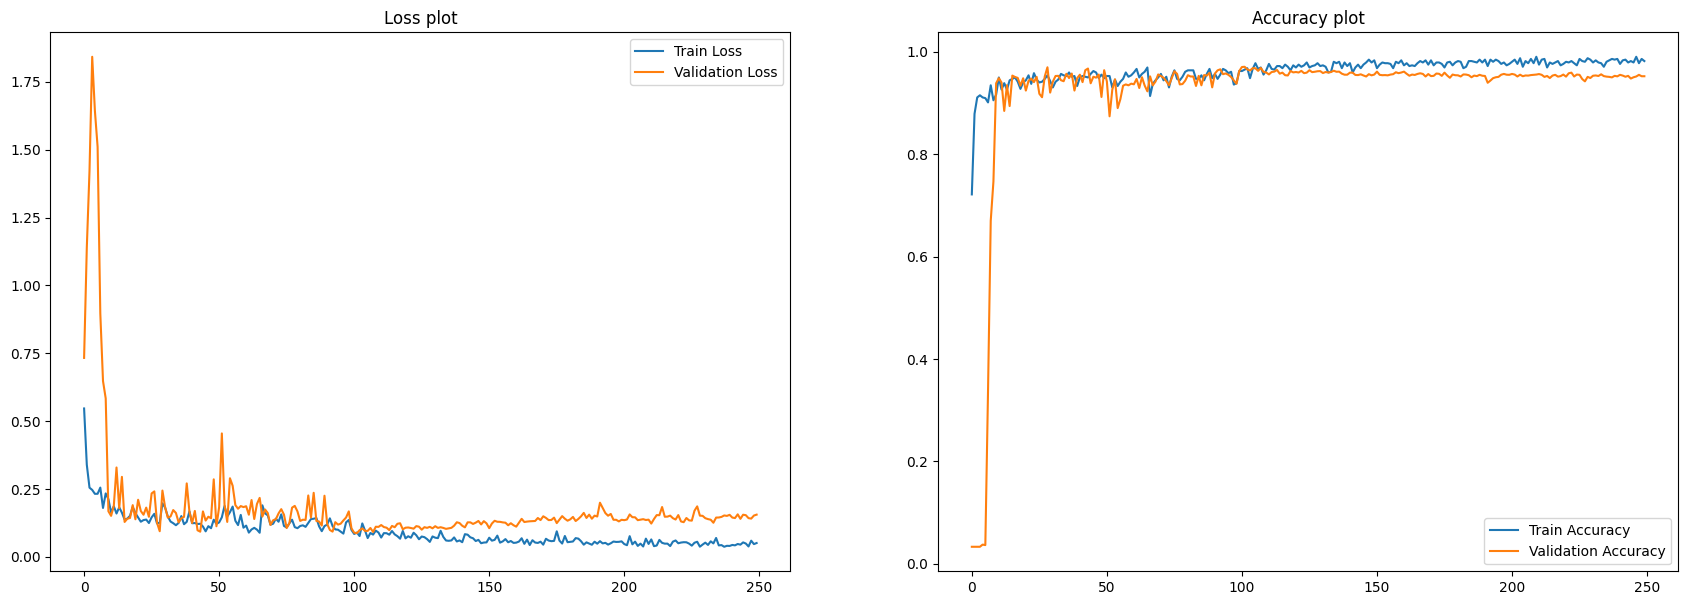

In [31]:
plot_loss_and_accuracy(train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr)

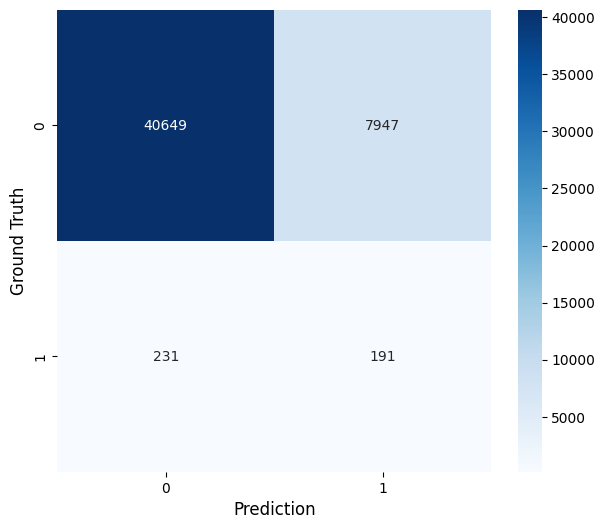


Sensitivity :  0.45260663507109006
Specificity :  0.8364680220594287
F1-Score: 0.044626168224299066
AUC: 0.6652273079250179



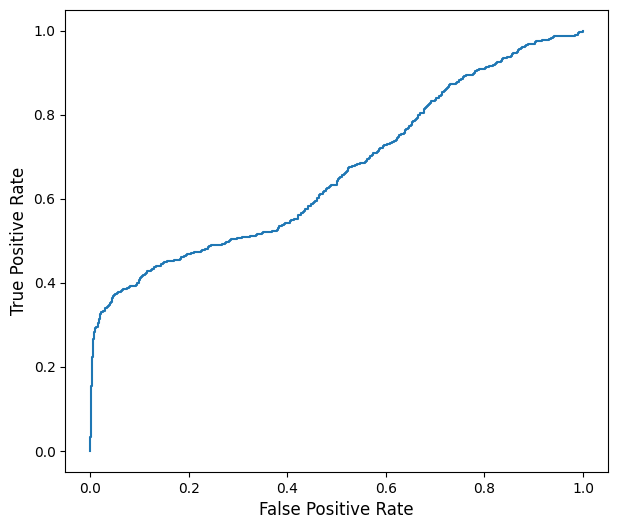

In [32]:
evaluate_model(model, test_loader)

In [33]:
model = CustomNet(92) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
train_loss_arr, train_acc_arr = train(model, criterion, optimizer, scheduler, full_train_loader, None, num_epochs=250)

[Epoch   0] [13:44:42]	 Train Loss: 0.5683 Train Acc: 0.68 Train Sens: 0.59 Train Spec: 0.77
[Epoch   1] [13:44:42]	 Train Loss: 0.3725 Train Acc: 0.85 Train Sens: 0.88 Train Spec: 0.82
[Epoch   2] [13:44:42]	 Train Loss: 0.3071 Train Acc: 0.88 Train Sens: 0.87 Train Spec: 0.89
[Epoch   3] [13:44:42]	 Train Loss: 0.2905 Train Acc: 0.89 Train Sens: 0.87 Train Spec: 0.91
[Epoch   4] [13:44:42]	 Train Loss: 0.2519 Train Acc: 0.90 Train Sens: 0.91 Train Spec: 0.89
[Epoch   5] [13:44:43]	 Train Loss: 0.2398 Train Acc: 0.91 Train Sens: 0.91 Train Spec: 0.91
[Epoch   6] [13:44:43]	 Train Loss: 0.2245 Train Acc: 0.92 Train Sens: 0.92 Train Spec: 0.92
[Epoch   7] [13:44:43]	 Train Loss: 0.2025 Train Acc: 0.93 Train Sens: 0.93 Train Spec: 0.93
[Epoch   8] [13:44:43]	 Train Loss: 0.1991 Train Acc: 0.92 Train Sens: 0.92 Train Spec: 0.92
[Epoch   9] [13:44:43]	 Train Loss: 0.1782 Train Acc: 0.94 Train Sens: 0.93 Train Spec: 0.94
[Epoch  10] [13:44:43]	 Train Loss: 0.1936 Train Acc: 0.93 Train Sens:

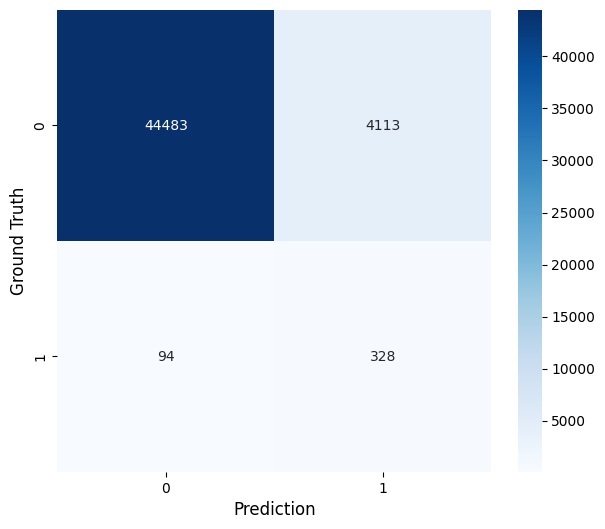


Sensitivity :  0.7772511848341233
Specificity :  0.9153634043954235
F1-Score: 0.13489615463705532
AUC: 0.9208330098746255



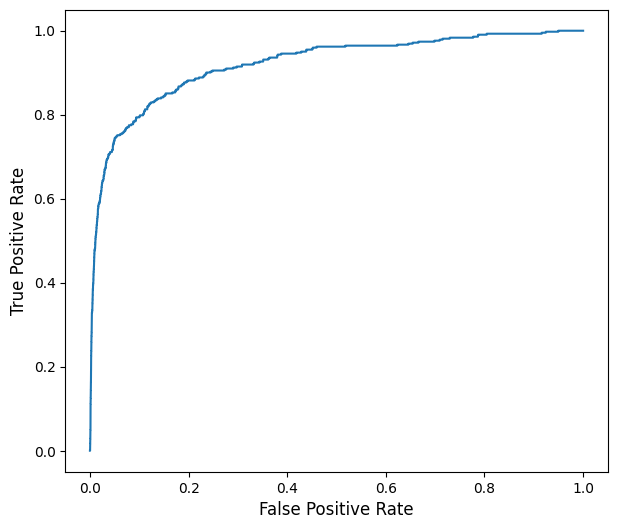

In [34]:
evaluate_model(model, test_loader)

100%|██████████| 49018/49018 [00:28<00:00, 1701.36it/s]


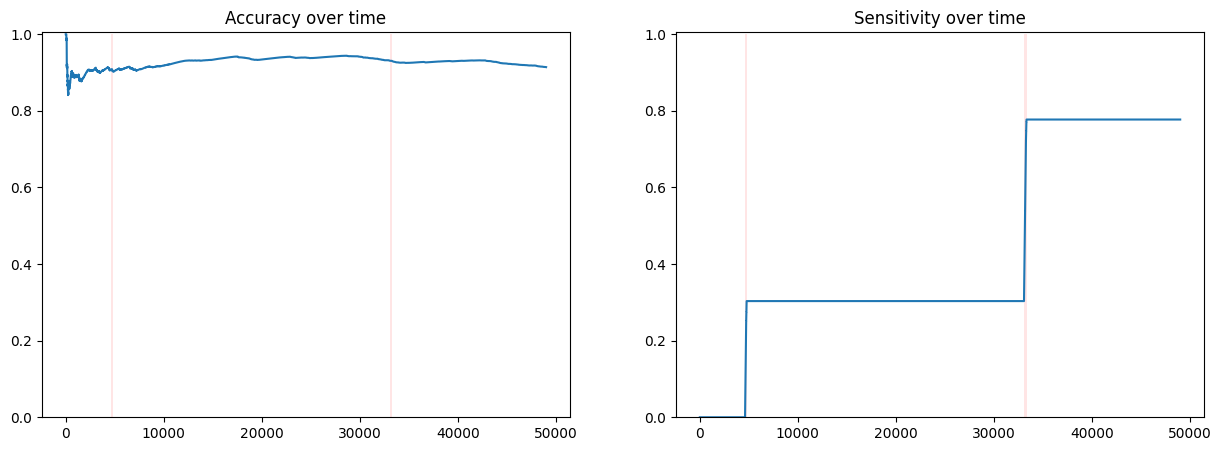

In [35]:
acc_arr_without_update, sen_arr_without_update = get_accuracy_and_sensitivity_over_time(model, test_dataset)
draw_accuracy_and_sensitivity_over_time(acc_arr_without_update, sen_arr_without_update, test_dataset)

In [36]:
model_checkpoint_path = os.path.join(constants.RESULT_PATH, 'checkpoint.pt')
torch.save(model.state_dict(), model_checkpoint_path)

In [44]:
model = CustomNet(92)
model.load_state_dict(torch.load(model_checkpoint_path))
optimizer = torch.optim.SGD(model.last_layer.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

acc_arr_with_update, sen_arr_with_update, _, raw_predictions = adaptive_learning_phase(model, test_dataset, optimizer, criterion, hc_s=5, hc_ns=600, ct_s=0.6, ct_ns=0.99)

100%|██████████| 49018/49018 [00:34<00:00, 1433.79it/s]

Count of update: [145, 203]


In [45]:
raw_predictions.shape

torch.Size([49018, 2])

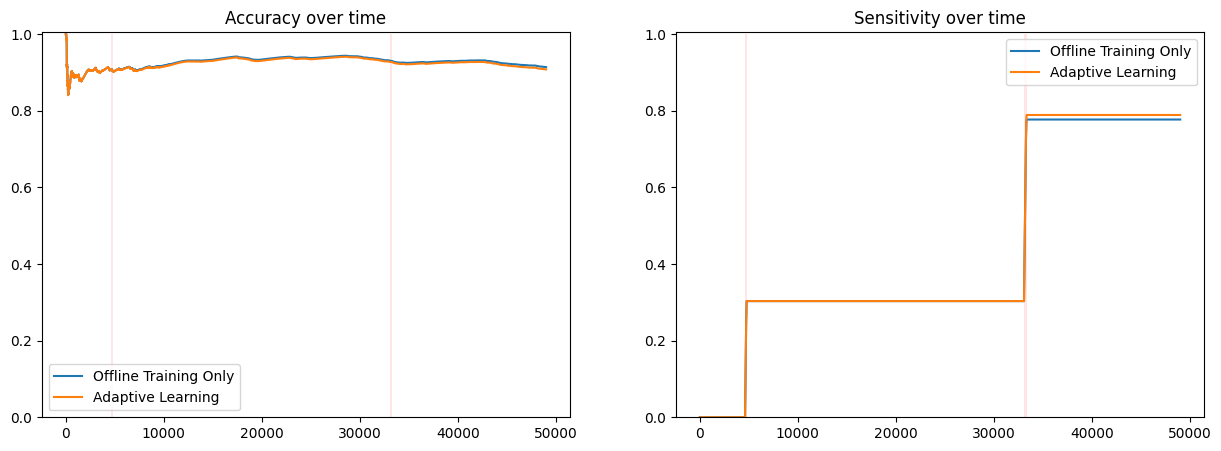

In [46]:
draw_accuracy_and_sensitivity_over_time(acc_arr_without_update, sen_arr_without_update, test_dataset, acc_arr_with_update, sen_arr_with_update)

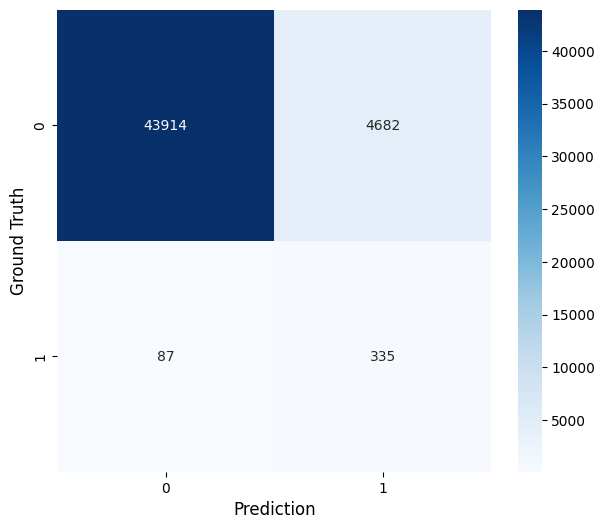


Sensitivity :  0.7938388625592417
Specificity :  0.9036546217795703
F1-Score: 0.12318440889869463
AUC: 0.9209392880033423



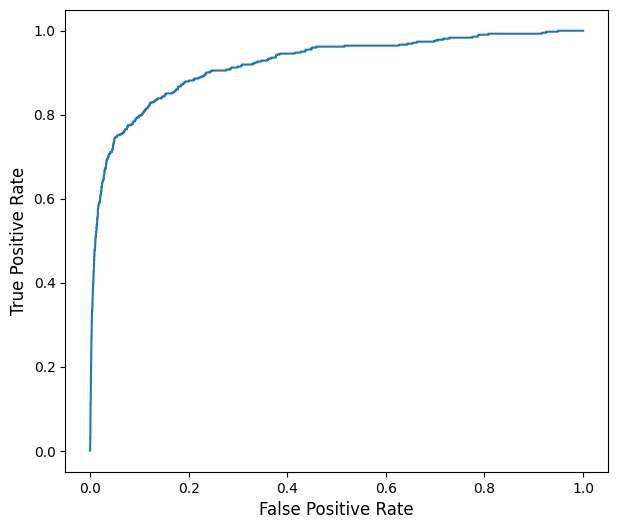

In [47]:
evaluate_model(model, test_loader)